In [4]:
%pip install cvxpy

  Obtaining dependency information for cvxpy from https://files.pythonhosted.org/packages/63/60/b800666fc77b6950464eaa0060db25473fa2eac70b9c60a0709515d05594/cvxpy-1.4.1-cp311-cp311-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for osqp>=0.6.2 from https://files.pythonhosted.org/packages/9a/08/bd3cacf6b99d639f99b276219553e74f8f800888ec0e01a39cb0ca22f0f1/osqp-0.6.3-cp311-cp311-macosx_10_9_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 1.8 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for clarabel>=0.5.0 from https://files.pythonhosted.org/packages/55/1e/16864d79381d95d5c1eea427295b8d927c7964f1b5a388ad8c3d5b75ab3a/clarabel-0.6.0-cp37-abi3-macosx_10_9_x86_64.macosx_11_0_arm64.macosx_10_9_universal2.whl.metadata
  Obtaining dependency information for scs>=3.0 from https://files.pythonhosted.org/packages/83/60/177a341f6c5caa2f003f24f33ea845acd15f190f9cad216304e8074fca70/scs-3.2.4.post1-cp311-cp311-macosx_10_9_x86_64.whl.meta

In [11]:
import numpy as np
import cvxpy as cp

def T(M, num_samples=10):
    U, _, Vt = np.linalg.svd(M, full_matrices=False)
    n, m = M.shape
    res = []
    for _ in range(num_samples):
        X = np.random.rand(m, n) * 2 - 1
        Y = np.random.rand(n, m) * 2 - 1
        T = U @ X + Y @ Vt
        res.append(T.tolist())
    return res

def Omega(M, num_samples=10):
    res = []
    nz_idx = np.nonzero(M)
    for _ in range(num_samples):
        N = np.zeros_like(M)
        for i, j in zip(*nz_idx):
            if np.random.rand() < 0.5:
                N[i, j] = M[i, j]
        res.append(N.tolist())
    return res

def zeta(M):
    matrices_T = T(M)
    max_inf_norm = 0
    for N_array in matrices_T:
        N = cp.Parameter(shape=M.shape, value=N_array)
        problem = cp.Problem(cp.Minimize(-cp.norm(N, 'inf')),
            constraints=[cp.norm(N, 2) <= 1])
        problem.solve()
        if problem.value is not None:
            max_inf_norm = max(max_inf_norm, -problem.value)
    return max_inf_norm

def mu(M):
    matrices_Omega = Omega(M)
    max_spectral_norm = 0
    for N_array in matrices_Omega:
        N = cp.Parameter(shape=M.shape, value=N_array)
        problem = cp.Problem(cp.Maximize(cp.norm(N, 2)),
                             constraints=[cp.norm(N, 'inf') <= 1])
        problem.solve()
        if problem.value is not None:
            print("Sol found")
            max_spectral_norm = max(max_spectral_norm, problem.value)
    return max_spectral_norm

def find_matrices(M, num_trials=1000):
    valid_decompositions = []
    n, m = M.shape

    for _ in range(num_trials):
        A = np.random.rand(n, m)
        B = M - A

        if zeta(A) * mu(B) < 1/6:
            valid_decompositions.append((A, B))

    return valid_decompositions

M = np.random.rand(10, 10)
decompositions = find_matrices(M)
print(f"Found {len(decompositions)} decompositions!")

Found 1000 decompositions!


In [13]:
import numpy as np
import pandas as pd
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix, csc_matrix, random
from sklearn.decomposition import TruncatedSVD
from scipy import sparse
import time
import tqdm

def generate_random_csr(n_rows, n_cols, density=0.2):
    sparse_matrix = sparse.random(n_rows, n_cols, density=density, format='csr')
    nnz = sparse_matrix.indptr[-1]
    sparse_matrix.data = np.random.randint(128, size=nnz)
    return sparse_matrix

def sparse_random_matrix(m, n, density=0.1):
    A = random(m, n, density=density, format='csr')
    nnz = A.indptr[-1]
    A.data = np.random.randn(nnz)
    return A

def soft_threshold(x, lambda_):
    return np.sign(x) * np.maximum(np.abs(x) - lambda_, 0)

def robust_pca(D, lambda_, tol, maxIter):
    m, n = D.shape
    Y = D.copy()
    L = np.zeros_like(D)
    S = np.zeros_like(D)
    mu = 1e-3  # TODO: tune
    rho = 1.5  # TODO: tune
    error = tol + 1
    k = 0

    # Perform ADMM iterations
    while k < maxIter and error > tol:
        # Update L
        U, Sigma, VT = svds(Y - S + Y/mu, k=min(m, n)-1)
        Sigma_thresh = np.diag(np.maximum(Sigma - 1/mu, 0))
        L = U @ Sigma_thresh @ VT

        S = soft_threshold(Y - L + Y/mu, lambda_/mu)

        Y += mu * rho * (D - L - S)

        error = np.linalg.norm(D - L - S, 'fro') / np.linalg.norm(D, 'fro')

        k += 1

    return L, S

# synthetic data set for testing
m, n = 100, 50  # dimensions of the matrix
rank = 5        # rank of the low-rank component
sparsity = 0.1  # sparsity level of the sparse component

# low-rank matrix
U = np.random.randn(m, rank)
V = np.random.randn(rank, n)
L_true = U @ V

# sparse matrix
S_true = sparse_random_matrix(m, n, density=sparsity).A

# data matrix
D = L_true + S_true

# params (for Robust PCA)
lambda_ = 1 / np.sqrt(max(m, n))
tol = 1e-5
maxIter = 1000

L, S = robust_pca(D, lambda_, tol, maxIter)

print(f"Rank of recovered low-rank matrix: {np.linalg.matrix_rank(L)}")
print(f"Sparsity level of recovered sparse matrix: {np.count_nonzero(S) / (m*n)}")
print("Done with Robust PCA simulation")

Rank of recovered low-rank matrix: 5
Sparsity level of recovered sparse matrix: 0.1166
Done with Robust PCA simulation


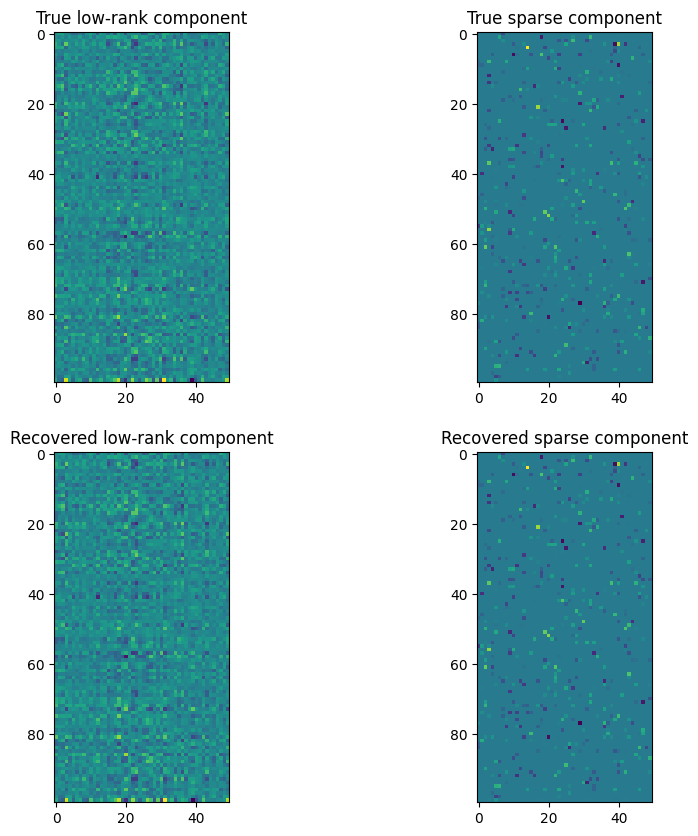

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(L_true)
plt.title("True low-rank component")
plt.subplot(2, 2, 2)
plt.imshow(S_true)
plt.title("True sparse component")
plt.subplot(2, 2, 3)
plt.imshow(L)
plt.title("Recovered low-rank component")
plt.subplot(2, 2, 4)
plt.imshow(S)
plt.title("Recovered sparse component")
plt.show()

In [6]:
import cvxpy as cp

# synthetic data set for testing
m, n = 100, 50  # dimensions of the matrix
rank = 5        # rank of the low-rank component
sparsity = 0.1  # sparsity level of the sparse component

# low-rank matrix
U = np.random.randn(m, rank)
V = np.random.randn(rank, n)
L_true = U @ V

# rnd sparse matrix
S_true = sparse_random_matrix(m, n, density=sparsity).A

# data matrix
D = L_true + S_true

L = cp.Variable((m, n))
S = cp.Variable((m, n))
lambda_ = 1 / np.sqrt(max(m, n))

# Robust PCA
problem = cp.Problem(cp.Minimize(cp.normNuc(L) + lambda_ * cp.norm1(S)),
                     [D == L + S])

problem.solve(solver=cp.SCS)

# low-rank
L_optimal = L.value
# sparse
S_optimal = S.value

print("Rank of the recovered low-rank matrix:", np.linalg.matrix_rank(L_optimal))
print("Sparsity level of the recovered sparse matrix:", np.count_nonzero(S_optimal) / (m * n))

Rank of the recovered low-rank matrix: 50
Sparsity level of the recovered sparse matrix: 1.0


In [15]:
import cvxpy as cp

epsilon = 1e-5

# synthetic data set for testing
m, n = 100, 50  # dimensions of the matrix
rank = 5        # rank of the low-rank component
sparsity = 0.1  # sparsity level of the sparse component

# low-rank matrix
U = np.random.randn(m, rank)
V = np.random.randn(rank, n)
L_true = U @ V

# rnd sparse matrix
S_true = sparse_random_matrix(m, n, density=sparsity).A

# data matrix
D = L_true + S_true

L = cp.Variable((m, n))
S = cp.Variable((m, n))
lambda_ = 1 / np.sqrt(max(m, n))

# Robust PCA
problem = cp.Problem(cp.Minimize(cp.normNuc(L) + lambda_ * cp.norm1(S)),
                     [cp.norm(D - L - S, "fro") <= epsilon])

problem.solve(solver=cp.SCS)

# low-rank
L_optimal = L.value
# sparse
S_optimal = S.value

print("Rank of the recovered low-rank matrix:", np.linalg.matrix_rank(L_optimal))
print("Sparsity level of the recovered sparse matrix:", np.count_nonzero(S_optimal) / (m * n))

Rank of the recovered low-rank matrix: 50
Sparsity level of the recovered sparse matrix: 1.0


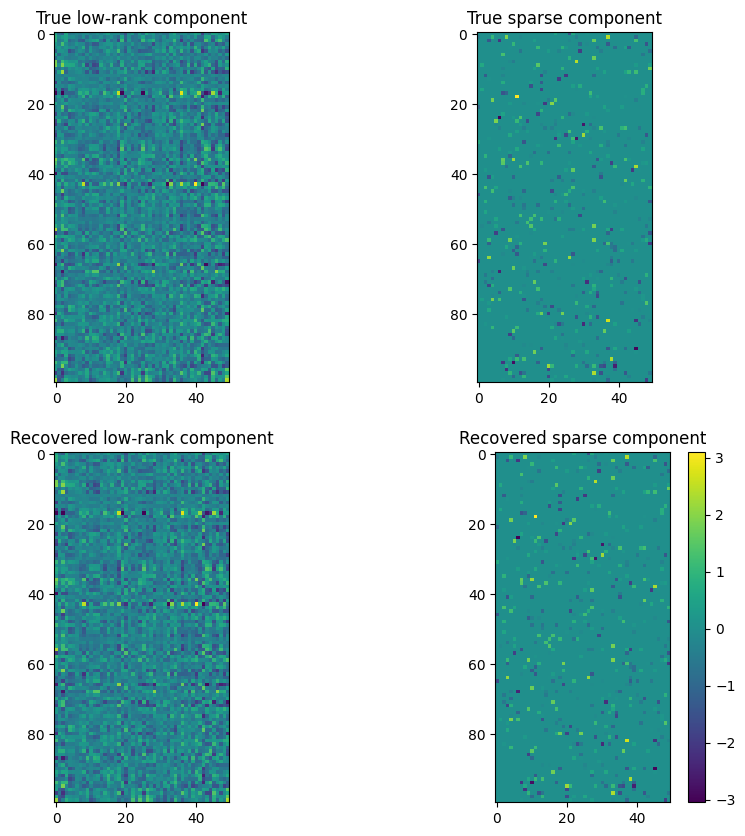

In [17]:
# Create a visualization of the results in the cell above
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(L_true)
plt.title("True low-rank component")
plt.subplot(2, 2, 2)
plt.imshow(S_true)
plt.title("True sparse component")
plt.subplot(2, 2, 3)
plt.imshow(L_optimal)
plt.title("Recovered low-rank component")
plt.subplot(2, 2, 4)
plt.imshow(S_optimal)
plt.title("Recovered sparse component")
plt.colorbar()
plt.show()